# 02a - Model Training

## I. Preliminaries

Import the libraries and functions for model training and hyperparameter search.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import pickle


from metaboDGD.util import data, train
from metaboDGD.src import model
import yaml
plt.rcParams["font.family"] = 'Arial'

## II. Retrieve Dataframe and Cohorts

Initialize the filenames and directories of the normal and tumor sample dataframes and cohorts.

In [2]:
dir = 'sept_outputs/'
df_normal_fname = 'CombinedDataset_CAMP_Normal.csv'
df_tumor_fname = 'CombinedDataset_CAMP_Tumor.csv'
cohorts_normal_fname = 'cohorts_Normal.pkl'
cohorts_tumor_fname = 'cohorts_Tumor.pkl'

Read the `.csv` and `.pkl` files to get the dataframes and cohorts, respectively.

In [3]:
np_normal_lbls, np_raw_normal_lbls, np_normal_log, cohorts_normal = \
    data.load_dataframe_and_cohort(dir, df_normal_fname, cohorts_normal_fname)

np_tumor_lbls, np_raw_tumor_lbls, np_tumor_log, cohorts_tumor = \
    data.load_dataframe_and_cohort(dir, df_tumor_fname, cohorts_tumor_fname)

c:\Users\Alfonso Miguel Cruz\Desktop\scDGD\metaboDGD\metaboDGD\util\data.py:261: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

## III. Training the DGD Model

Initialize the `DataLoader` object, which stores the metabolite abundance of normal samples.

In [4]:
train_all_loader = \
    data.create_dataloaders(np_train_abun=np_normal_log,
                            np_train_lbls=np_normal_lbls,
                            batch_size=256)

Initialize the DGD model.

In [5]:
config_model = yaml.safe_load(open('model.yaml', 'r'))

dgd_model = \
    model.MetaboDGD(
        **config_model
    )

Train the DGD model.

In [6]:
config_train = yaml.safe_load(open('train.yaml', 'r'))

dgd_model, train_rep, history, cm = \
    train.train_dgd(
        dgd_model=dgd_model,
        train_loader=train_all_loader,
        **config_train
    )

0
50


Get the training and validation loss, and clustering accuracy curves after training the model.

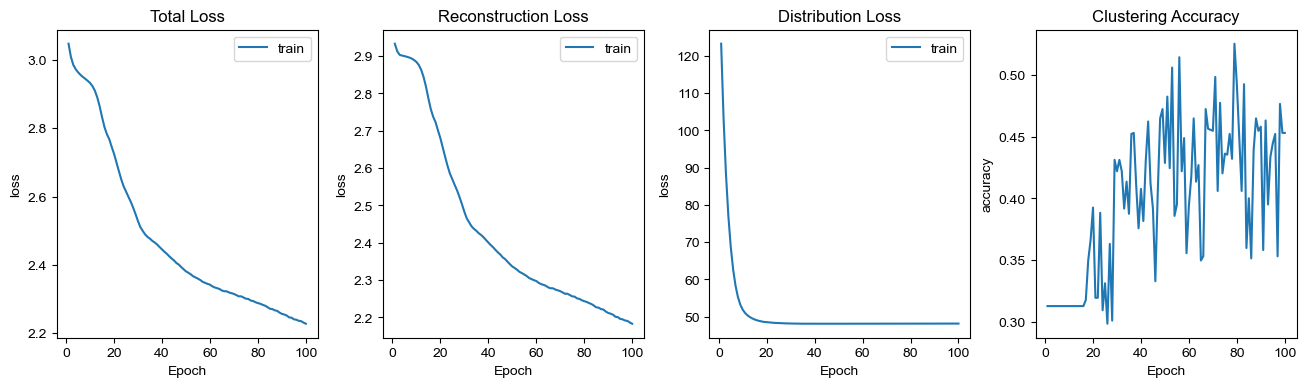

In [7]:
train.get_history_plot(history, inc_gmm_acc=True, with_val_plot=False)

In [8]:
history.tail()

,train_loss,train_recon_loss,train_dist_loss,cluster_acc,epoch
95,2.239631,2.194928,48.158252,0.452181,96
96,2.236560,2.191856,48.159265,0.353188,97
97,2.235441,2.190736,48.160967,0.476510,98
98,2.231282,2.186576,48.161807,0.453020,99
99,2.227889,2.183182,48.163341,0.453020,100


## IV. Saving the Model and Data

In [9]:
torch.save(dgd_model.dec.state_dict(), dir+'torch_outputs_dec.pt')
torch.save(dgd_model.gmm.state_dict(), dir+'torch_outputs_gmm.pt')
torch.save(train_rep.state_dict(), dir+'torch_outputs_train_rep.pt')

In [10]:
results = {
    'np_normal_lbls': np_normal_lbls,
    'np_raw_normal_lbls': np_raw_normal_lbls,
    'np_normal_log': np_normal_log,
    'cohorts_normal': cohorts_normal,
    'np_tumor_lbls': np_tumor_lbls,
    'np_raw_tumor_lbls': np_raw_tumor_lbls,
    'np_tumor_log': np_tumor_log,
    'cohorts_tumor': cohorts_tumor,
    'history': history,
    'cm': cm,
}

f = open(dir + 'results.pkl', 'wb')
pickle.dump(results, f)
f.close()

In [ ]:
# tumor_rep_final, dec_out_final = dgd_model.get_representations(np_tumor_log, np_tumor_lbls, np_tumor_log.shape[0])

In [ ]:
import math
def get_bic(model, n, nl_L):
    k = sum(m.numel() for m in model.dec.parameters())
    k += sum(m.numel() for m in model.gmm.parameters())
    
    # nl_L = -log(L)
    bic = k * math.log(n) + 2 * nl_L

    return float(bic)

get_bic(dgd_model, np_normal_log.shape[1], history.iloc[-1]['train_loss'])

In [54]:
for i in range(0,10):
    for j in range(11,20):
        print(i)
        break

0
1
2
3
4
5
6
7
8
9


In [13]:
test_a = np.copy(tumor_rep_final.detach().numpy())

In [15]:
test_b = np.copy(tumor_rep_final.detach().numpy())

In [16]:
test_a

array([[ 0.03049225, -0.00960253,  0.01785977, ..., -0.05165031,
         0.00946614,  0.00397142],
       [ 0.03102096, -0.00993416,  0.01788753, ..., -0.05196783,
         0.0092754 ,  0.00409685],
       [ 0.0318954 , -0.01051637,  0.01811207, ..., -0.05267183,
         0.00903606,  0.0044163 ],
       ...,
       [-0.04938139,  0.05270185, -0.03034581, ..., -0.04309305,
         0.03577881, -0.03553833],
       [-0.0493417 ,  0.05273447, -0.03032201, ..., -0.04310689,
         0.03580428, -0.03551001],
       [-0.04931849,  0.05270215, -0.03031684, ..., -0.04312615,
         0.03579215, -0.03550516]], shape=(2424, 100), dtype=float32)

In [18]:
np.all(test_a == test_b)

np.True_

In [12]:
# tumor_results = {
#     'tumor_rep_final': tumor_rep_final.detach().numpy(),
#     'dec_out_final': dec_out_final.detach().numpy()
# }

# f = open(dir + 'tumor_results.pkl', 'wb')
# pickle.dump(tumor_results, f)
# f.close()

## V. Hyperparameter Grid Search (OPTIONAL)

TODO: Get updated hyperparameter search script from the server

In [ ]:
import wandb

def grid_search(config=None):
    with wandb.init(config=config):
        c = wandb.config
        
        skf = StratifiedKFold(n_splits=3)

        for i, (ti, vi) in enumerate(skf.split(df_log.to_numpy(), np.array(df_lbls))):
            pass

        dgd_cand = model.MetaboDGD(
            latent_dim=c.latent_dim,
            output_dim=df_log.shape[1],
            dec_hidden_layers_dim=[500, 1500],
            dec_output_prediction_type='mean',
            dec_output_activation_type='softplus',
            n_comp=8,
            cm_type='diagonal',
            softball_radius=c.softball_radius,
            softball_sharpness=c.softball_sharpness,
            gaussian_mean=c.gaussian_mean,
            gaussian_stddev=c.gaussian_stddev,
            dirichlet_alpha=c.dirichlet_alpha
        )

        dgd_cand, train_rep, test_rep, history, cm = train.train_dgd(
            dgd_model=dgd_cand,
            train_loader=train_loader,
            validation_loader=test_loader,
            n_epochs=250,
            lr_schedule_epochs=None,
            lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
            optim_betas=[0.5, 0.7],
            wd=1e-5,
        )

        wandb.log({"validation_reconstruction_loss": history.iloc[-1]['val_loss'],
                   "cluster_acc": history.iloc[-1]['cluster_acc']})


def execute_grid_search():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'cluster_acc',
            'goal': 'maximize'
        },
        'parameters': {
            'latent_dim': {
                'values': [20, 30],
            },
            'dirichlet_alpha': {
                'values': [0.5, 1.0],
            },
            'softball_radius': {
                'values': [3, 5, 7],
            },
            'softball_sharpness': {
                'values': [5, 10],
            },
            'gaussian_mean': {
                'values': [-6.0, -5.0],
            },
            'gaussian_stddev': {
                'values': [0.01, 0.25, 0.50]
            }
        }
    }

    sweep_id = wandb.sweep(
        sweep=sweep_config,
        project="my-first-project"
    )

    wandb.agent(
        sweep_id=sweep_id,
        function=grid_search
    )


# execute_grid_search()

In [ ]:
skf = StratifiedKFold(n_splits=3)
ave_cluster_acc = 0
ave_val_recon_loss = 0

for i, (ti, vi) in enumerate(skf.split(np_normal_log, np_normal_lbls)):
    ## Initialize train and validation Dataloaders
    train_loader, validation_loader = \
        data.create_dataloaders(np_train_abun=np_normal_log[ti],np_train_lbls=np_normal_lbls[ti],
                                np_validation_abun=np_normal_log[vi], np_validation_lbls=np_normal_lbls[vi],
                                batch_size=32)
    
    
    ## Initialize DGD model
    dgd_model = \
        model.MetaboDGD(
            latent_dim=50,
            output_dim=np_normal_log.shape[1],
            dec_hidden_layers_dim=[500, 1500],
            dec_output_prediction_type='mean',
            dec_output_activation_type='softplus',
            n_comp=8,
            cm_type='diagonal',
            softball_radius=5,
            softball_sharpness=10,
            gaussian_mean=-5.0,
            gaussian_stddev=0.25,
            dirichlet_alpha=2.0,
            
        )

    dgd_model, train_rep, val_rep, history, cm = \
        train.train_dgd(
            dgd_model=dgd_model,
            train_loader=train_loader,
            validation_loader=validation_loader,
            n_epochs=200,
            lr_schedule_epochs=None,
            lr_schedule=[1e-4, 1e-3, 1e-2], # dec, rep, gmm
            optim_betas=[0.5, 0.7],
            wd=1e-4,
        )
    
    ave_cluster_acc += history.iloc[-1]['cluster_acc']
    ave_val_recon_loss += history.iloc[-1]['val_loss']

    train.get_history_plot(history, inc_gmm_acc=True, with_val_plot=True)
    ans = input("Continue?")

ave_cluster_acc /= 3
ave_val_recon_loss /= 3

???

In [ ]:
# from collections import Counter
# # from umap import UMAP

# pca_counter = Counter(plt_np_normal_lbls)
# print(pca_counter)
# means_and_reps = np.vstack((train_rep.z.detach().numpy(),dgd_model.gmm.means.detach().numpy()))

# pca = PCA(n_components=2)
# pca_fit = pca.fit_transform(means_and_reps)

# # pca = UMAP(n_components=2)
# # pca_fit = pca.fit_transform(means_and_reps)

# fig, ax = plt.subplots(figsize=(20,20))

# i = 0
# j = 0

# # "#17104B"
# # "#FF9B9B"
# # "#94EBFF"
# # "#e2de0f"
# for c in cohorts_normal:
#     k = pca_counter[c]
#     j += k

#     for m in range(i, j):
#         ax.annotate(c, (pca_fit[m,0], pca_fit[m,1]), alpha=0.25)

#     if 'feces' in c:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c, c="#17104B")
#     elif 'plasma' in c:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c, c="#FF9B9B")
#     elif 'saliva' in c:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c, c="#94EBFF")
#     elif 'serum' in c:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c, c="#e2de0f")
#     elif 'tissue' in c:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c, c='#0fe283')
#     else:
#         ax.scatter(pca_fit[i:j,0], pca_fit[i:j,1], label=c)

#     i = j


# # ax.scatter(pca_fit[i:,0], pca_fit[i:,1], label='GMM Means', c='black', marker='*')
# ax.set_title('Normal Representations and Means in Latent Space')




# ax.set_xlabel(f'PC1 ({(pca.explained_variance_ratio_[0] * 100):.2f}%)', labelpad=10)
# ax.set_ylabel(f'PC2 ({(pca.explained_variance_ratio_[1] * 100):.2f}%)')
# ax.legend(bbox_to_anchor=(1.40, 1.025),loc='upper right', fancybox=False, framealpha=0.0, title='Analytical Platforms', alignment='left')

<!-- import pickle
def plt_load_dataframe_and_cohort(dir,
                              dataframe_fname,
                              cohort_fname):
    # Read the sample dataframe and convert to a numpy array
    df = pd.read_csv(dir + dataframe_fname)
    df.set_index('Unnamed: 0', inplace=True)
    df.index.name = None
    np_lbls = df.loc['cohort'].to_numpy()
    np_log = df.T.drop(columns=['cohort']).astype('float32').to_numpy()

    # Read the sample cohort dictionary
    fn = open(dir + cohort_fname, 'rb')
    cohorts = pickle.load(fn)
    fn.close()

    return np_lbls, np_log, cohorts

plt_np_normal_lbls, plt_np_normal_log, plt_cohorts_normal = \
    plt_load_dataframe_and_cohort(dir, df_normal_fname, cohorts_normal_fname) -->
